# Model Evaluation II

Last time, we saw a theoretical example of *overfitting*, in which we fit a machine learning model that perfectly fit the data it saw, but performed extremely poorly on fresh, unseen data. In this lecture, we'll observe overfitting in a more practical context, using the Titanic data set again. We'll then begin to study *validation* techniques for finding models with "just the right amount" of flexibility. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# assumes that you have run the function retrieve_data() 
# from "Introduction to ML in Practice" in ML_3.ipynb
titanic = pd.read_csv("data.csv")
titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


Recall that we diagnosed overfitting by testing our model against some new data. In this case, we don't have any more data. So, what we can do instead is *hold out* some data that we won't let our model see at first. This holdout data is called the *validation* or *testing* data, depending on the use to which we put it. In contrast, the data that we allow our model to see is called the *training* data. `sklearn` provides a convenient function for partitioning our data into training and holdout sets called `train_test_split`. The default and generally most useful behavior is to randomly select rows of the data frame to be in each set. 

In [39]:
from sklearn.model_selection import train_test_split

np.random.seed(1234) # for reproducibility
train, test = train_test_split(titanic, test_size = 0.3) # hold out 30% of data

train.shape, test.shape

((620, 8), (267, 8))

Now we have two data frames. As you may recall from a previous lecture, we need to do some data cleaning, and split them into predictor variables `X` and target variables `y`. 

In [40]:
from sklearn import preprocessing
def prep_titanic_data(data_df):
    df = data_df.copy()
    le = preprocessing.LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    df = df.drop(['Name'], axis = 1)
    
    X = df.drop(['Survived'], axis = 1).values
    y = df['Survived'].values
    
    return(X, y)

In [41]:
X_train, y_train = prep_titanic_data(train)
X_test,  y_test  = prep_titanic_data(test)

Now we're able to train our model on the `train` data, and then evaluate its performance on the `val` data. This will help us to diagnose and avoid overfitting.

Let's try using the decision tree classifier again. As you may remember, the `DecisionTreeClassifier()` class takes an argument `max_depth` that governs how many layers of decisions the tree is allowed to make. Larger `max_depth` values correspond to more complicated trees. In this way, `max_depth` is a model complexity parameter, similar to the `degree` when we did polynomial regression. 

For example, with a small `max_depth`, the model scores on the training and validation data are relatively close. 

In [42]:
from sklearn import tree
T = tree.DecisionTreeClassifier(max_depth = 3)

T.fit(X_train, y_train)
T.score(X_train, y_train), T.score(X_test, y_test)

(0.8290322580645161, 0.8164794007490637)

On the other hand, if we use a much higher `max_depth`, we can achieve a substantially better score on the training data, but our performance on the validation data has not improved by much, and might even suffer. 

In [43]:
T = tree.DecisionTreeClassifier(max_depth = 20)

T.fit(X_train, y_train)
T.score(X_train, y_train), T.score(X_test, y_test)

(0.9903225806451613, 0.7602996254681648)

That looks like overfitting! The model achieves a near-perfect score on the training data, but a much lower one on the test data. 

[Text(0, 0.5, 'Performance (score)'), Text(0.5, 0, 'Complexity (depth)')]

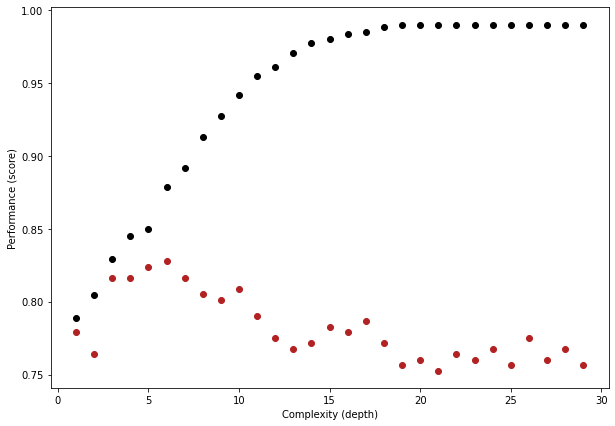

In [44]:
fig, ax = plt.subplots(1, figsize = (10, 7))

for d in range(1,30):
    T = tree.DecisionTreeClassifier(max_depth = d)

    T.fit(X_train, y_train)
    
    ax.scatter(d, T.score(X_train, y_train), color = "black")
    ax.scatter(d, T.score(X_test, y_test), color = "firebrick")
    
ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)")

Observe that the training score (black) always increases, while the test score (red) tops out around 83\% and then even begins to trail off slightly. It looks like the optimal depth might be around 5-7 or so, but there's some random noise that can prevent us from being able to determine exactly what the optimal depth is. 

This noise reflects the fact that we took a single, random subset of the data for testing. In a more systematic experiment, we would draw many different subsets of the data for each value of depth and average over them. This is what *cross-validation* does, and we'll talk about it in the next lecture.